In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
from collections import Counter
import glob
import os
import pickle
import re
import time

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from gensim.models.ldamulticore import LdaMulticore
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

NOTEBOOKS_DIR = os.path.abspath(os.getcwd())
ROOT_DIR = os.path.split(NOTEBOOKS_DIR)[0]
PROCESSED_DATA_DIR = os.path.join(ROOT_DIR, 'data', 'processed')

FINAL_DF_FILEPATH = os.path.join(PROCESSED_DATA_DIR, 'final.csv')
ML_ONLY_FILEPATH = os.path.join(PROCESSED_DATA_DIR, 'machine_learning_only.csv')

In [3]:
df_ml = pd.read_csv(ML_ONLY_FILEPATH, encoding='utf-8')

In [5]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_ml = tfidf_vectorizer.fit_transform(df_ml['description'])
features = np.array(tfidf_vectorizer.get_feature_names())
km = KMeans(n_clusters=10, random_state=42)
X_transformed = km.fit_transform(tfidf_ml)

In [7]:
km.cluster_centers_

array([[0.00000000e+00, 3.15767255e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.57660922e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.09075074e-05, 2.70653376e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.29918817e-04, 1.44855644e-03, 0.00000000e+00, ...,
        0.00000000e+00, 2.47584791e-05, 0.00000000e+00],
       [7.26436918e-05, 7.50976399e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.05268850e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [8]:
# Let's look at some articles from each "topic" we've discovered.
for i in set(km.labels_):
    print(i)
    in_label_group = km.labels_ == i
    label_idxs = np.arange(len(in_label_group))[in_label_group]
    np.random.shuffle(label_idxs)
    for title in df_ml['title'].reset_index(drop=True)[label_idxs].head().values:
        print(">>>", title)
        print()

0
>>> Spectral Multigraph Networks for Discovering and Fusing Relationships in
  Molecules

>>> The Geometric Block Model

>>> Geometric Representations of Random Hypergraphs

>>> Variational Recurrent Neural Networks for Graph Classification

>>> Optimal Transport for structured data with application on graphs

1
>>> Prediction and Control with Temporal Segment Models

>>> Sensory Anticipation of Optical Flow in Mobile Robotics

>>> Metatrace Actor-Critic: Online Step-size Tuning by Meta-gradient Descent
  for Reinforcement Learning Control

>>> Learning from Scarce Experience

>>> Exploration Potential

2
>>> Robust Maximization of Non-Submodular Objectives

>>> Exponential inequalities for nonstationary Markov Chains

>>> Some techniques in density estimation

>>> Anomaly Detection via Graphical Lasso

>>> Time-Sensitive Bandit Learning and Satisficing Thompson Sampling

3
>>> Inference in Hidden Markov Models with Explicit State Duration
  Distributions

>>> Sparse-posterior Gaussi

In [14]:
random_1000_idxs = np.random.choice(range(48564), 1000)

In [10]:
X_transformed.shape

(48564, 10)

In [17]:
from matplotlib import colors

In [18]:
# Let's plot these in 2D space and look for patterns.
X_embedded = TSNE(n_components=2).fit_transform(X_transformed[random_1000_idxs])
x_vals = X_embedded[:, 0]
y_vals = X_embedded[:, 1]

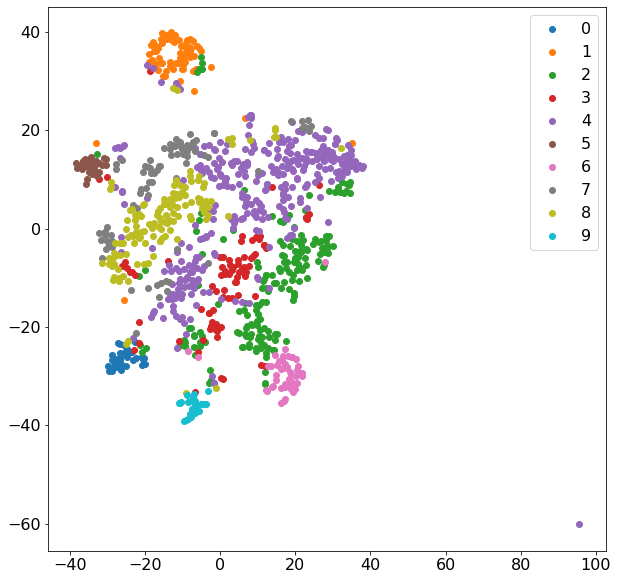

In [20]:
plt.figure(figsize=(10, 10))
color_seq = list(colors.TABLEAU_COLORS.items())[:len(km.labels_[random_1000_idxs])]
for i in set(km.labels_[random_1000_idxs]):
    in_label_group = km.labels_[random_1000_idxs] == i
    label_idxs = np.arange(len(in_label_group))[in_label_group]
    plt.scatter(x_vals[label_idxs], y_vals[label_idxs], c=color_seq[i][1], label=i)
plt.legend()
#plt.savefig("images/article-clusters-10.png")
plt.show()

In [32]:
df_ml['title'].reset_index(drop=True)[random_1000_idxs[np.argwhere(x_vals > 80)][0]].values

array(['Is AmI (Attacks Meet Interpretability) Robust to Adversarial Examples?'],
      dtype=object)

In [33]:
df_ml['description'].reset_index(drop=True)[random_1000_idxs[np.argwhere(x_vals > 80)][0]].values

array(['  No.\n'], dtype=object)

Aha—the big outlier here is an empty description.